# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### 1. Preprocessing the data

In [2]:
political_parties_colors = {
    "Socialdemokratiet": (179, 39, 34, 255),
    "Venstre": (0, 102, 151, 255),
    "Moderaterne": (108, 57, 229, 255),
    "Socialistisk Folkeparti": (221, 8, 120, 255),
    "Danmarksdemokraterne": (138, 195, 255, 255),
    "Liberal Alliance": (33, 198, 207, 255),
    "Det Konservative Folkeparti": (158, 186, 39, 255),
    "Enhedslisten": (237, 128, 25, 255),
    "Radikale Venstre": (113, 50, 128, 255),
    "Nye Borgerlige": (5, 79, 92, 255),
    "Alternativet": (42, 143, 57, 255),
    "Dansk Folkeparti": (243, 205, 65, 255),
    "Frie Grønne, Danmarks Nye Venstrefløjsparti": (0, 230, 106, 255),
    "Kristendemokraterne": (186, 186, 186, 255),
    "Løsgænger": (0, 0, 0, 255)
}

# Normalize the RGBA values to the range [0, 1]
normalized_colors = {party: tuple(component / 255 for component in rgba)
                     for party, rgba in political_parties_colors.items()}

In [3]:
all_data = pd.read_excel('alldata.xlsx')
all_data.drop(columns=['storkreds', 'navn', 'alder'], inplace=True)

elected_data = pd.read_excel('electeddata.xlsx')
elected_names = elected_data['navn']
elected_data.drop(columns=['storkreds', 'navn', 'alder'], inplace=True)

questions_dr = pd.read_excel('drq.xlsx')
questions_tv2 = pd.read_excel('tv2q.xlsx')

all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 867 entries, 0 to 866
Data columns (total 50 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   530     867 non-null    int64 
 1   531     867 non-null    int64 
 2   533     867 non-null    int64 
 3   534     867 non-null    int64 
 4   535     867 non-null    int64 
 5   537     867 non-null    int64 
 6   538     867 non-null    int64 
 7   540     867 non-null    int64 
 8   541     867 non-null    int64 
 9   543     867 non-null    int64 
 10  544     867 non-null    int64 
 11  545     867 non-null    int64 
 12  546     867 non-null    int64 
 13  547     867 non-null    int64 
 14  548     867 non-null    int64 
 15  550     867 non-null    int64 
 16  551     867 non-null    int64 
 17  552     867 non-null    int64 
 18  553     867 non-null    int64 
 19  555     867 non-null    int64 
 20  556     867 non-null    int64 
 21  557     867 non-null    int64 
 22  559     867 non-null    in

### 2. An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.

#### TSNE for all candidates

CPU times: total: 22.6 s
Wall time: 1.72 s


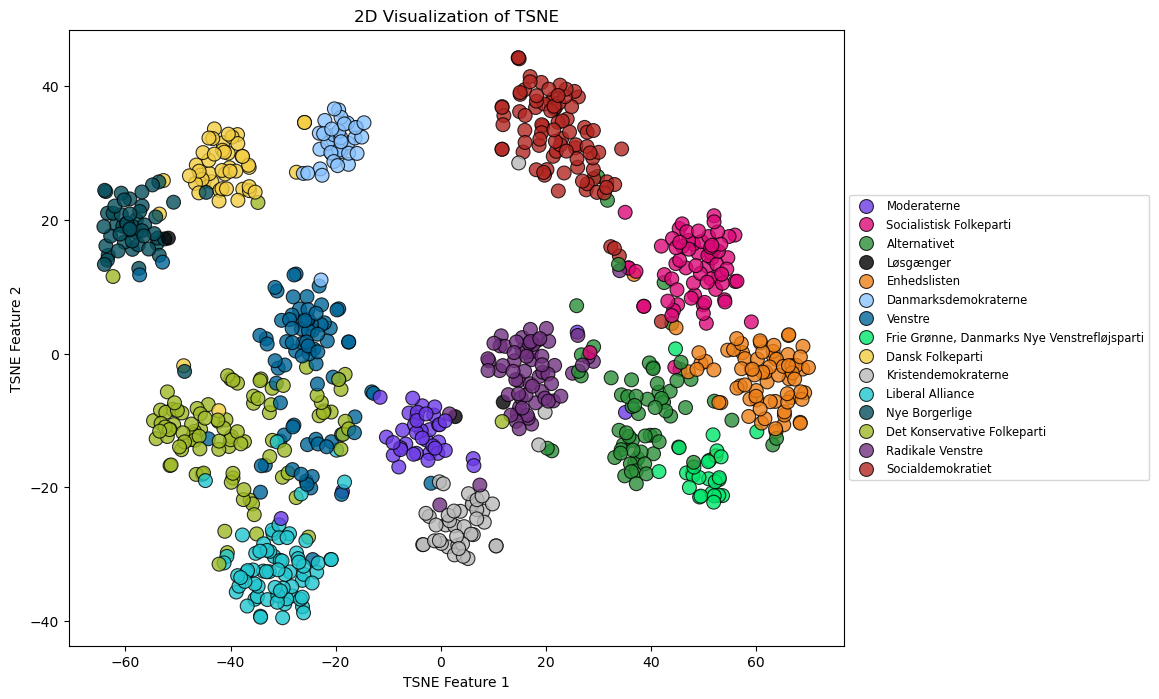

In [4]:
features_data = all_data.drop(columns=['parti'])
target = all_data['parti']

def visualize_2d(x, labels):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels, s=100, alpha=0.8,
                    palette=normalized_colors, edgecolor="black")
    plt.xlabel('TSNE Feature 1')
    plt.ylabel('TSNE Feature 2')
    plt.title('2D Visualization of TSNE')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    plt.show()

%time tsne_2d = TSNE(n_components=2, perplexity=10, early_exaggeration=12, learning_rate='auto', init='pca', n_jobs=4).fit_transform(features_data)

visualize_2d(tsne_2d, target)

##### Tsne for elected candidates

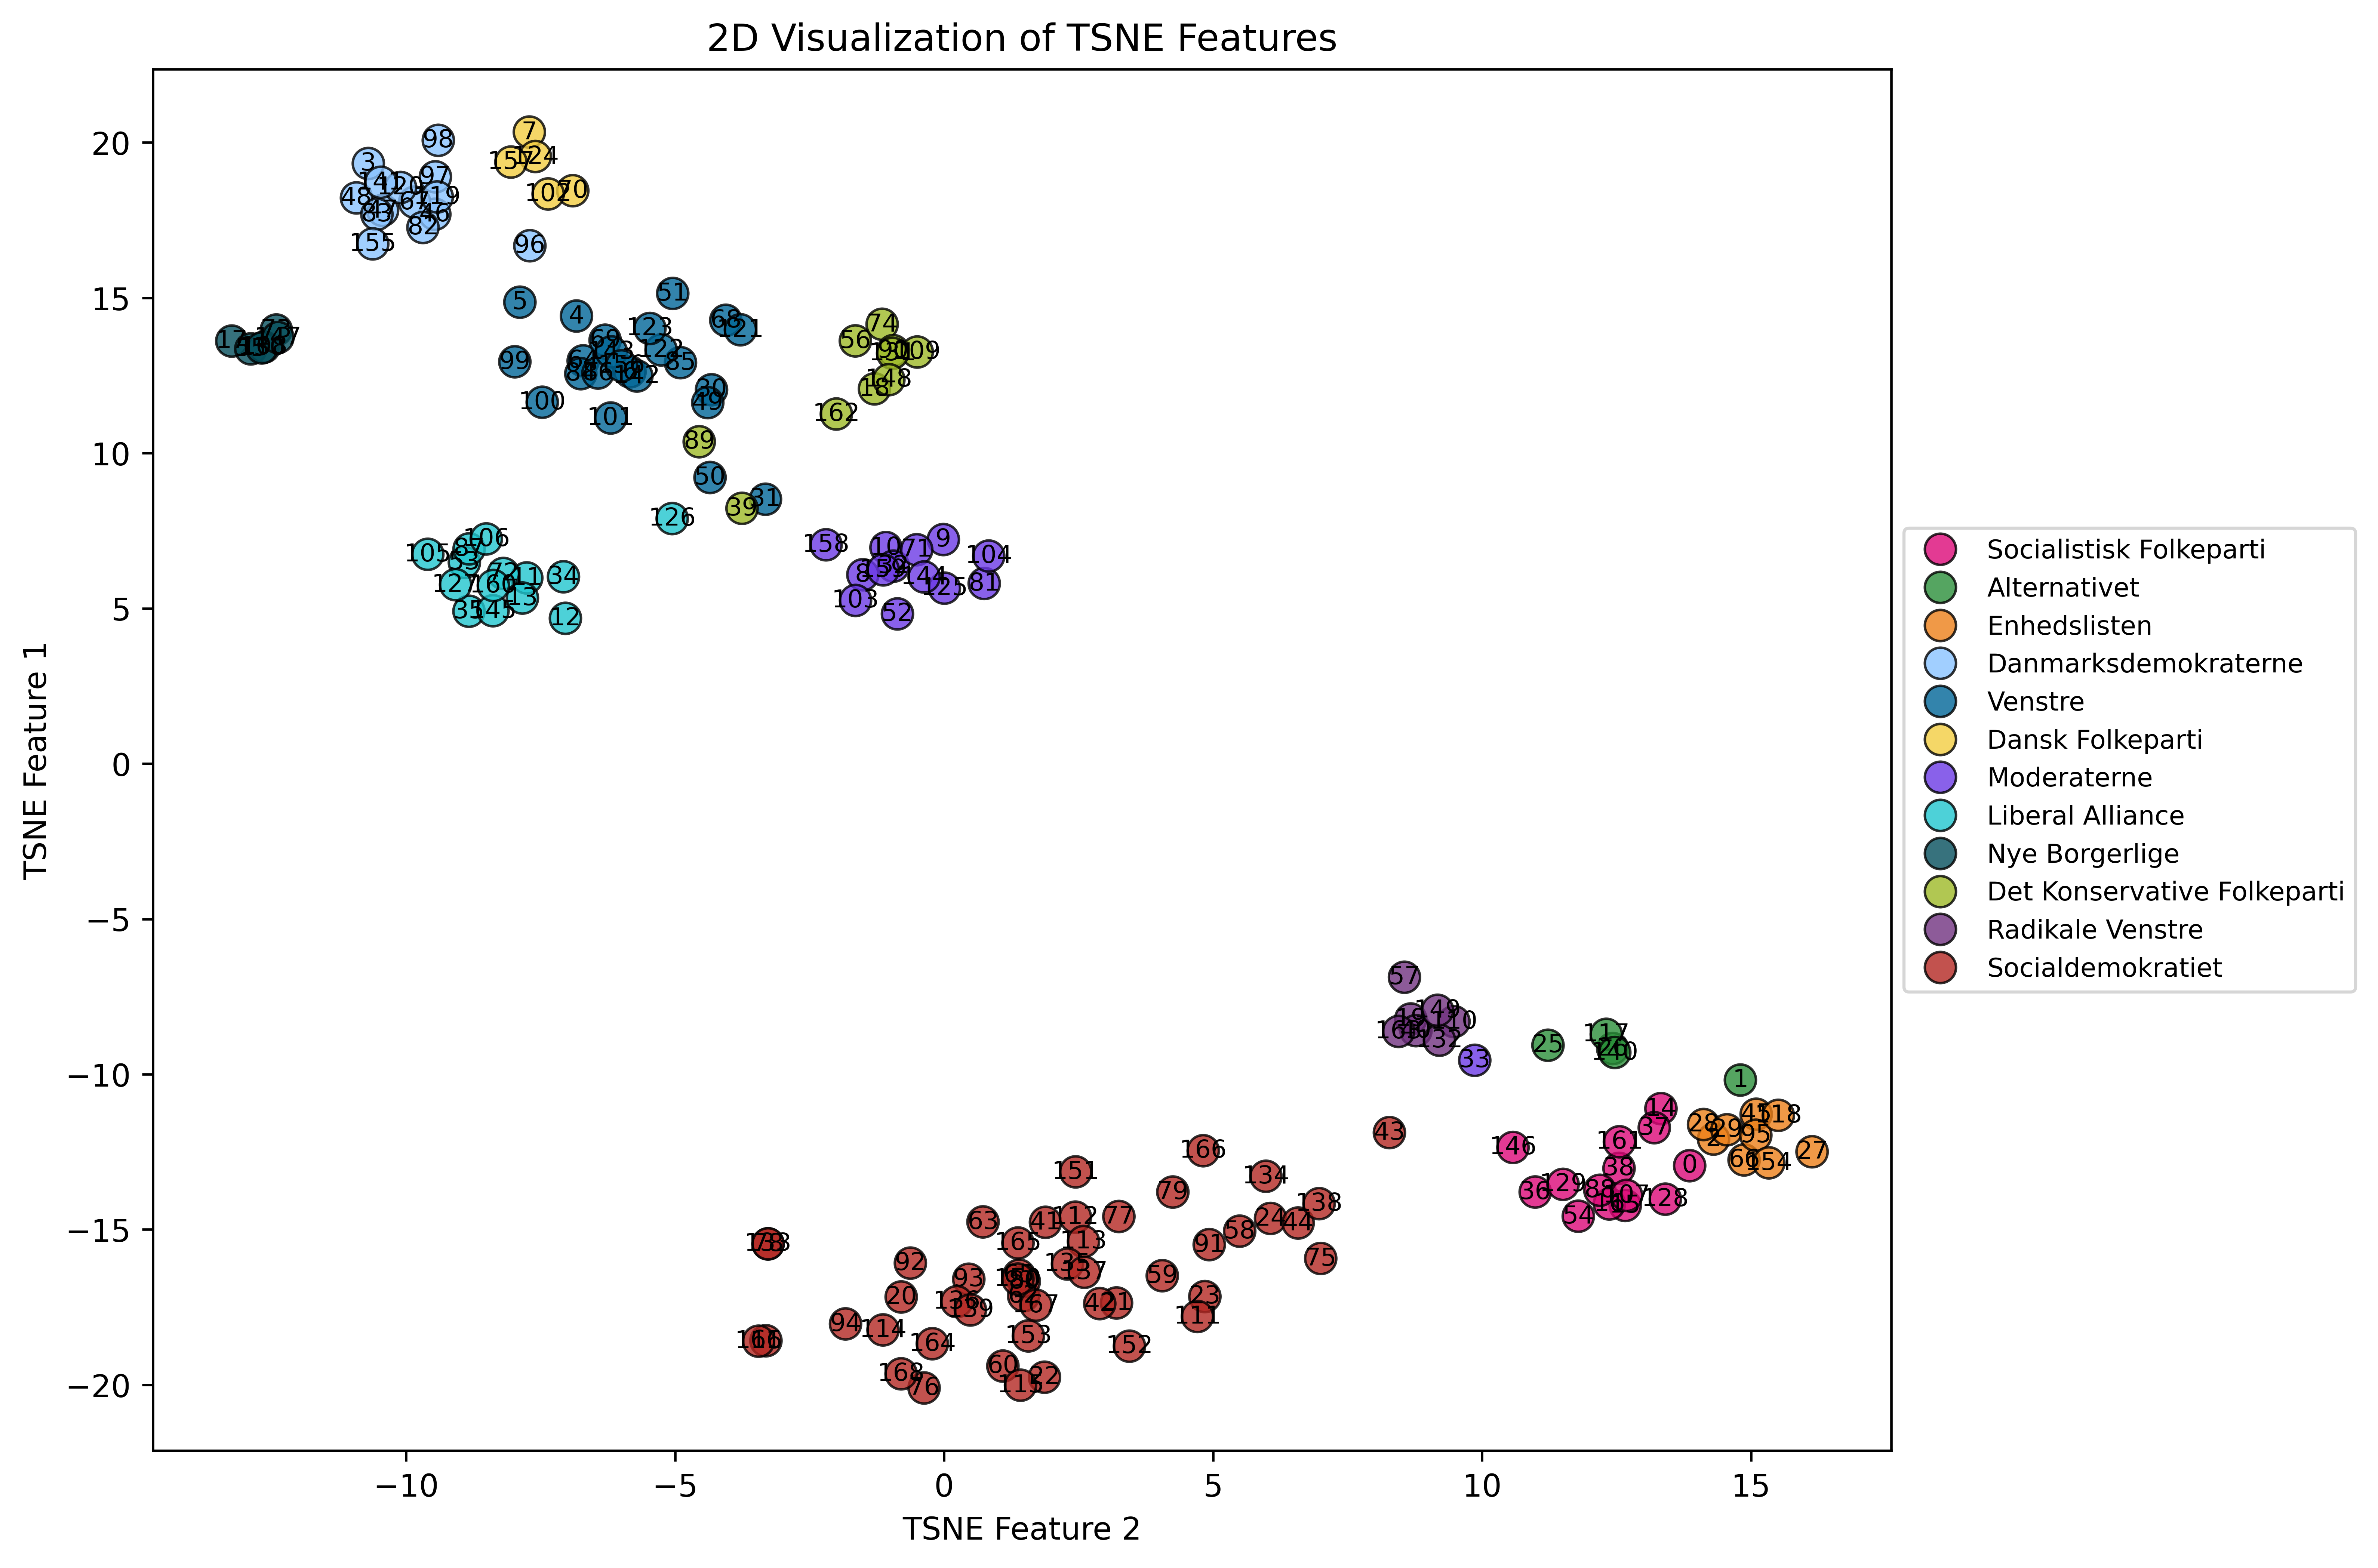

In [29]:
features_elected_data = elected_data.drop(columns=['parti'])
target_elected = elected_data['parti']

def visualize_2d(x, labels):
    plt.figure(figsize=(10, 8), dpi=600)
    sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels, s=100, alpha=0.8, edgecolor="black", palette=normalized_colors)
    
    for i, (x_val, y_val) in enumerate(x):
        plt.text(x_val, y_val, str(i), fontsize=8, ha='center', va='center', color='black')
    
    plt.xlabel('TSNE Feature 2')
    plt.ylabel('TSNE Feature 1')
    plt.title('2D Visualization of TSNE Features')
    
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')
    plt.show()

tsne_2d_elected = TSNE(n_components=2, perplexity=19, early_exaggeration=12, learning_rate='auto', init='pca', n_jobs=4, random_state=42).fit_transform(features_elected_data)

visualize_2d(tsne_2d_elected, target_elected)

Based on the plot above, the following politicians should belong to the other parties.

It means that based on their responses they have similar world view to parties they do not belong to.

For example politician with index 1 - Torsten Gejl is a representative of Alternativet partie while his responses to the questions would place him next to the politicians of Enhedslisten and Socialistik Folkeparti.

Similarly, Index 33: Jon Læssøe Stephensen is a representative of Moderaterne, while based on the answers, was placed near Radikale Venstre and Alternativet.

Other politicians listed below are significant outliers to their respective parties.

In [30]:
def display_name_by_index(index):
    if index < len(elected_names):
        print(f"Index {index}: {elected_names[index]}")
    else:
        print("Index out of range.")
display_name_by_index(1)
display_name_by_index(33)
display_name_by_index(39)
display_name_by_index(89)
display_name_by_index(126)


Index 1: Torsten Gejl
Index 33: Jon Læssøe Stephensen
Index 39: Helle Bonnesen
Index 89: Lise Bertelsen
Index 126: Lars-Christian Brask


c:\Users\mateu\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
c:\Users\mateu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


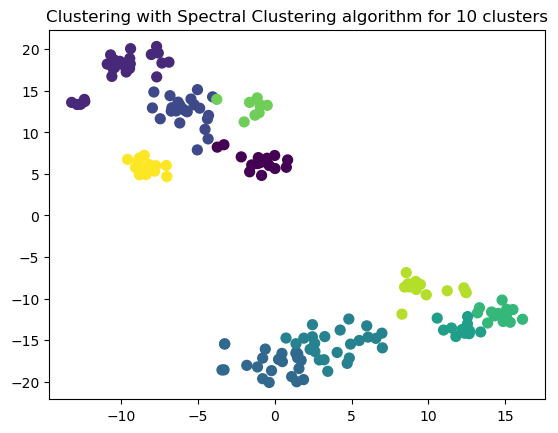

In [31]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=10, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(tsne_2d_elected)
plt.title('Clustering with Spectral Clustering algorithm for 10 clusters')
plt.scatter(tsne_2d_elected[:, 0], tsne_2d_elected[:, 1], c=labels,
            s=50, cmap='viridis')

Comparison of "2D Visualization of TSNE Features plot" with above "Clustering with Spectral Clustering algorithm for 10 clusters" give us following insights:
- Party with the biggest spread is Socialdemokratiet. Spectral clustering has proven that point by dividing this party into two different clusters.
- On the other hand, Radikale Venstre and Alternativet were merged into one cluster, because responses of their politicians were so similar.
- Similarly, Danmarksdemokraterne and Dansk Folkeparti were merged into one cluster.
- However, Endhendlisten and Socialistik Folkeparti were accurately left devided.

### 4. An analysis/description of which questions are most crucial concerning their placement on the axes.

In [36]:
# Perform PCA(2) and list the components
centered = features_data - np.mean(features_data, axis=0)
pca4 = PCA(n_components=2)
X_pca = pca4.fit_transform(centered)

questions_array = pca4.components_.flatten()
questions_array = np.absolute(questions_array)

arr = np.array(questions_array)
N = 10
res = np.argsort(-arr)[:N]

# Because of 2 lists mod indices by question count

res = res%49

# Print result

reslist = res.tolist()
print(f"{N} most important questions indices : " + str(reslist))


10 most important questions indices : [20, 44, 16, 18, 19, 36, 35, 1, 15, 30]


### 3.  Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question. 

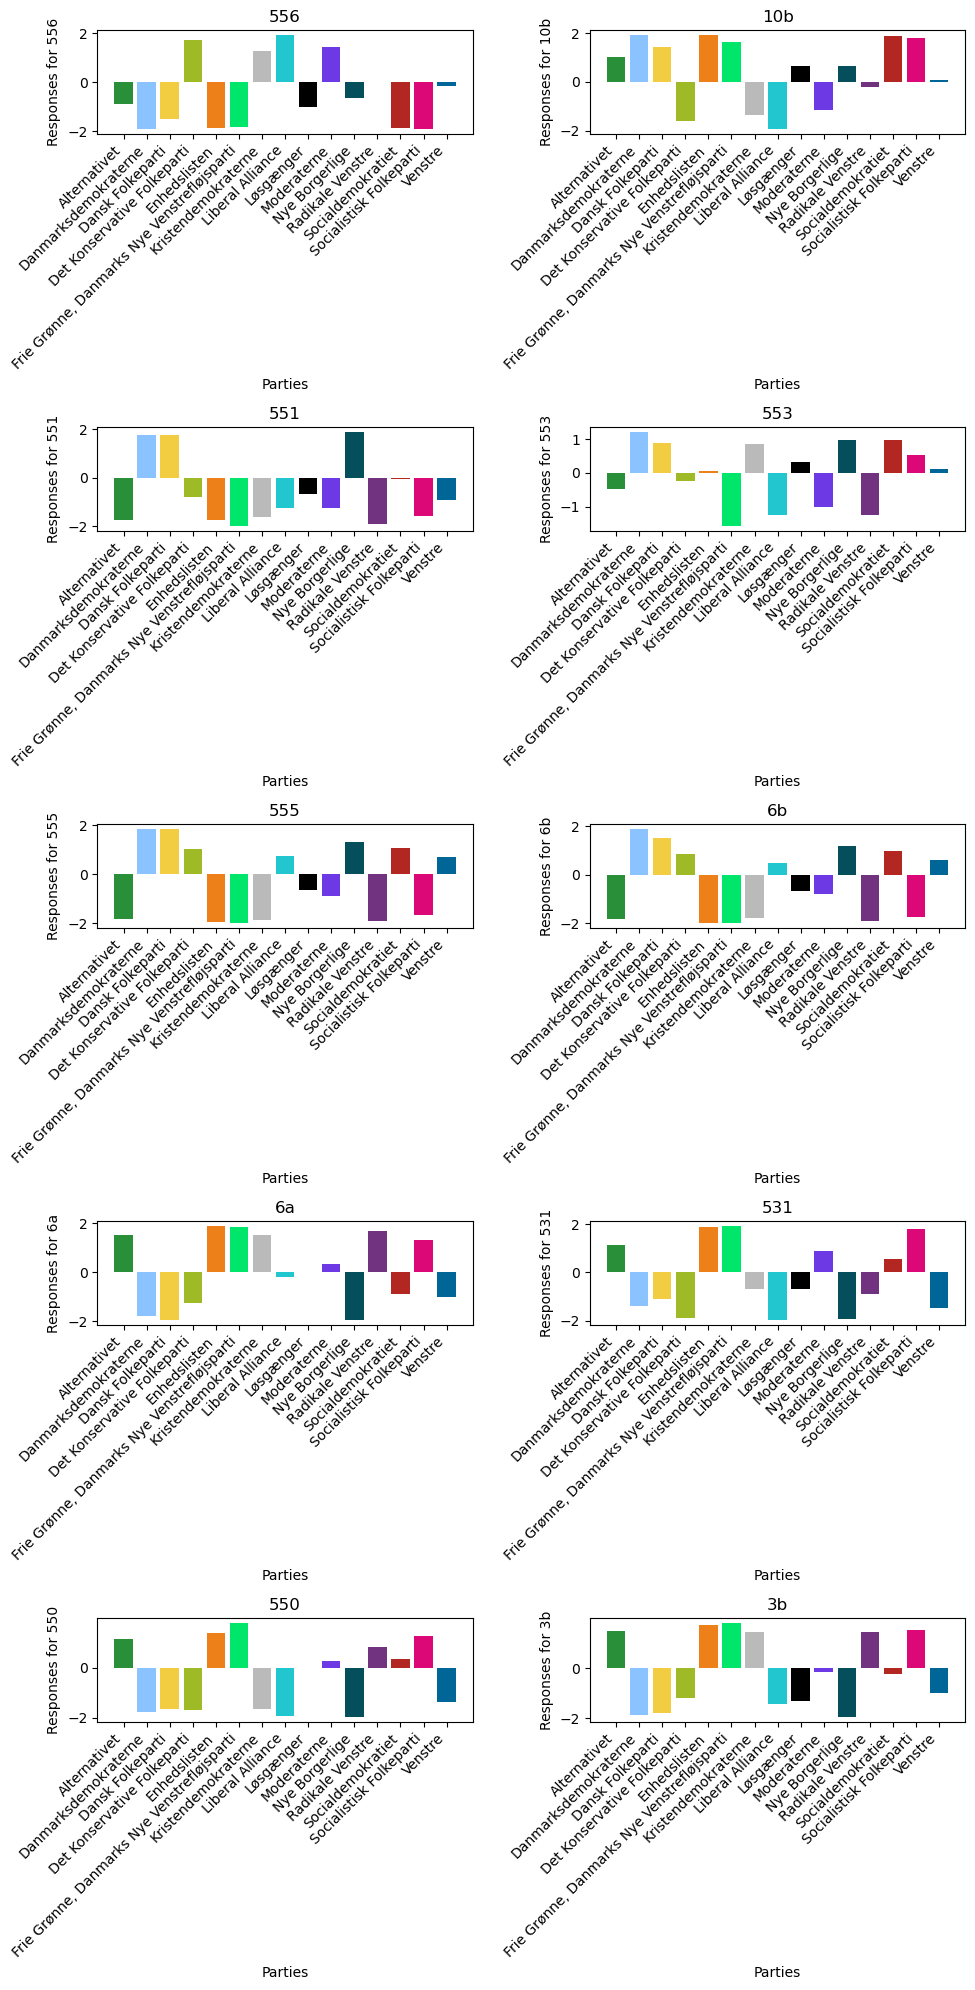

In [37]:

# Create a dataframe with the most important questions and name of the party of the respondent
party = all_data.pop('parti')
all_data.insert(49,'parti',party)

new_data_frame = all_data.iloc[:,res]
new_data_frame.insert(len(new_data_frame.columns),'parti',party)

data = new_data_frame.groupby('parti')

#Calculate the mean

mean = data.mean()

parties = mean.index
questions = mean.columns

nrows, ncols = 5, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 20))
axes = axes.flatten()  # Flatten the axes array for easier iteration

# Iterate through the questions and plot on each subplot
for i, question in enumerate(questions):
    ax = axes[i]  # Select the appropriate subplot

    x = np.arange(len(parties))
    bar_colors = [normalized_colors[party] for party in parties]
    ax.bar(x, mean[question], color=bar_colors)
    ax.set_xticks(x)
    ax.set_xticklabels(parties, rotation=45, ha='right')
    ax.set_xlabel('Parties')
    ax.set_ylabel(f'Responses for {question}')
    ax.set_title(f'{question}')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.tight_layout()

# Display the figure
plt.show()

The questions listed above are:
- 556: Den såkaldte Arne-pension skal afskaffes
- 10b: Den såkaldte Arne-pension, der giver mulighed for tidligere pension, skal bibeholdes, selvom der er mangel på arbejdskraft.
- 551: Der skal være permanent grænsekontrol mellem Danmark og Tyskland
- 553: Der skal udflyttes flere uddannelsespladser fra de store byer
- 555: Asylansøgere bør sendes til et land uden for EU - f.eks. Rwanda - mens deres ansøgning behandles
- 6b:  Det vil være en god idé at etablere et dansk asylmodtagecenter i Rwanda.
- 6a:  Den danske udlændingepolitik er for stram.
- 531: Der skal indføres en særlig skat på de allerhøjeste indkomster
- 550: Der skal indføres kvoter, der sikrer mindst 30 procent kvinder i virksomheders bestyrelser
- 3b:  Ulandsbistanden bør hæves.


### 5. A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**

We are centralizing the data to delete bias which can ensure that the principal components accurately capture the underlying structure of maximum variance in the data. 

In [38]:
print("Original shape: {}".format(str(centered.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (867, 49)
Reduced shape: (867, 2)


c:\Users\mateu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\mateu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\mateu\AppData\Local\Temp\ipykernel_15892\234475233.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='viridis', s=50)


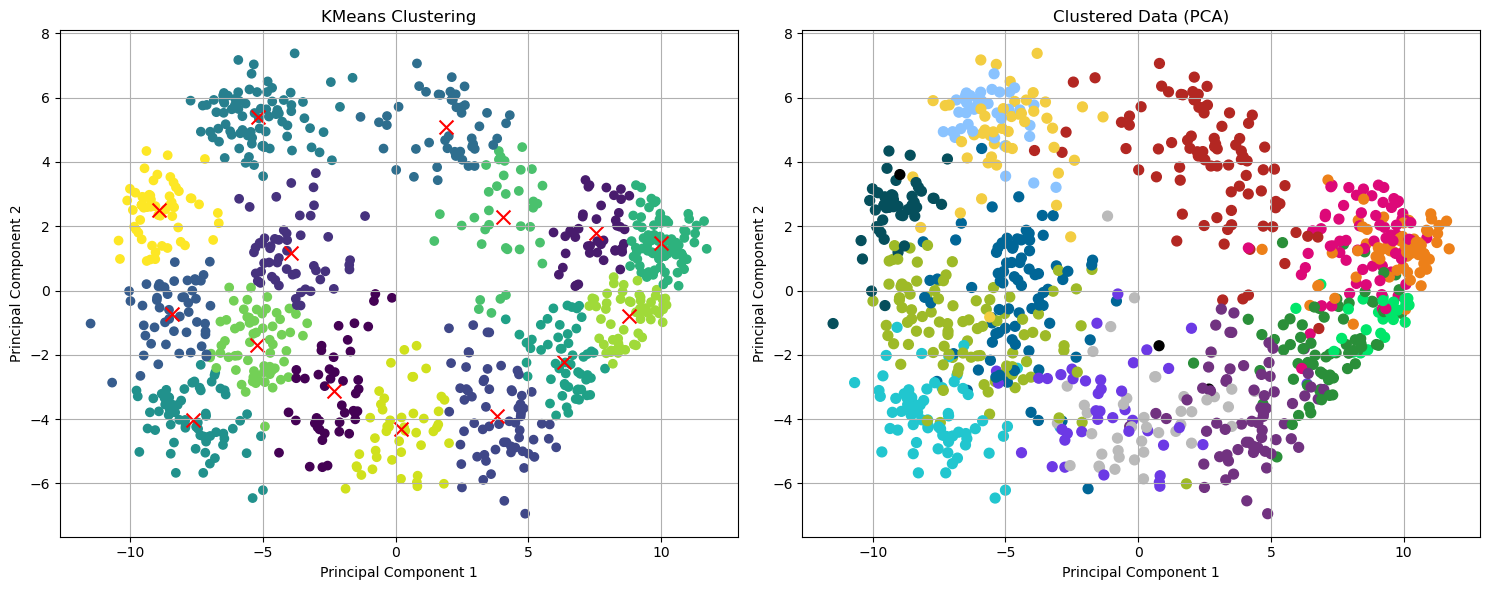

In [39]:
def do_kmeans(n):
    kmeans = KMeans(n_clusters=n)
    labels = kmeans.fit_predict(X_pca)

    plt.figure(figsize=(15, 6))

    # Plotting the kmeans as a first plot
    plt.subplot(1, 2, 1)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', label='Data Points')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='red', marker='x', label='Centroids')
    plt.title('KMeans Clustering')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    #plt.colorbar(scatter)
    plt.grid(True)

    # Plotting the data after PCA
    plt.subplot(1, 2, 2)
    colors = [normalized_colors[party] for party in target]
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='viridis', s=50)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Clustered Data (PCA)')
    plt.grid(True) 

    # Commented out so the plots will be the same size
    #handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=normalized_colors[party], markersize=10, label=party) for party in normalized_colors.keys()]
    #plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

    plt.tight_layout()
    plt.show()

do_kmeans(15)

c:\Users\mateu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\mateu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\mateu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\mateu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

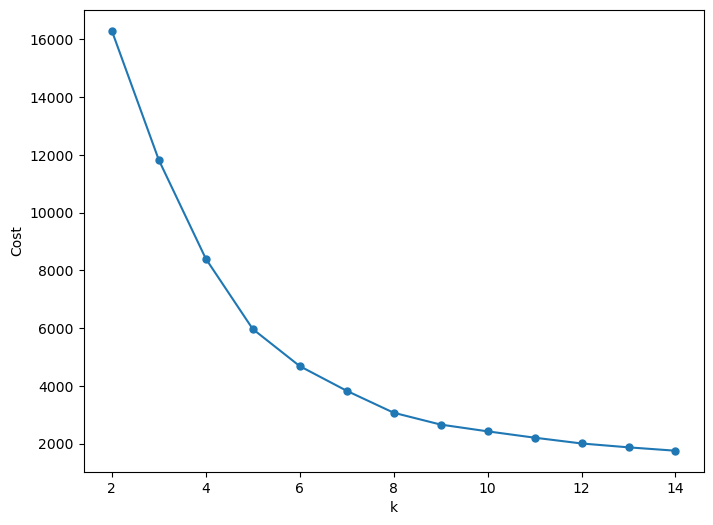

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
costs = []
ks = range(2, 15)
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_pca)
    costs.append(kmeans.inertia_)

ax.plot(ks, costs, '.-', markersize=10)
ax.set_xlabel('k')
ax.set_ylabel('Cost')
plt.show()

The elbow method tells us to use k=5.

c:\Users\mateu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\mateu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\mateu\AppData\Local\Temp\ipykernel_15892\234475233.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap='viridis', s=50)


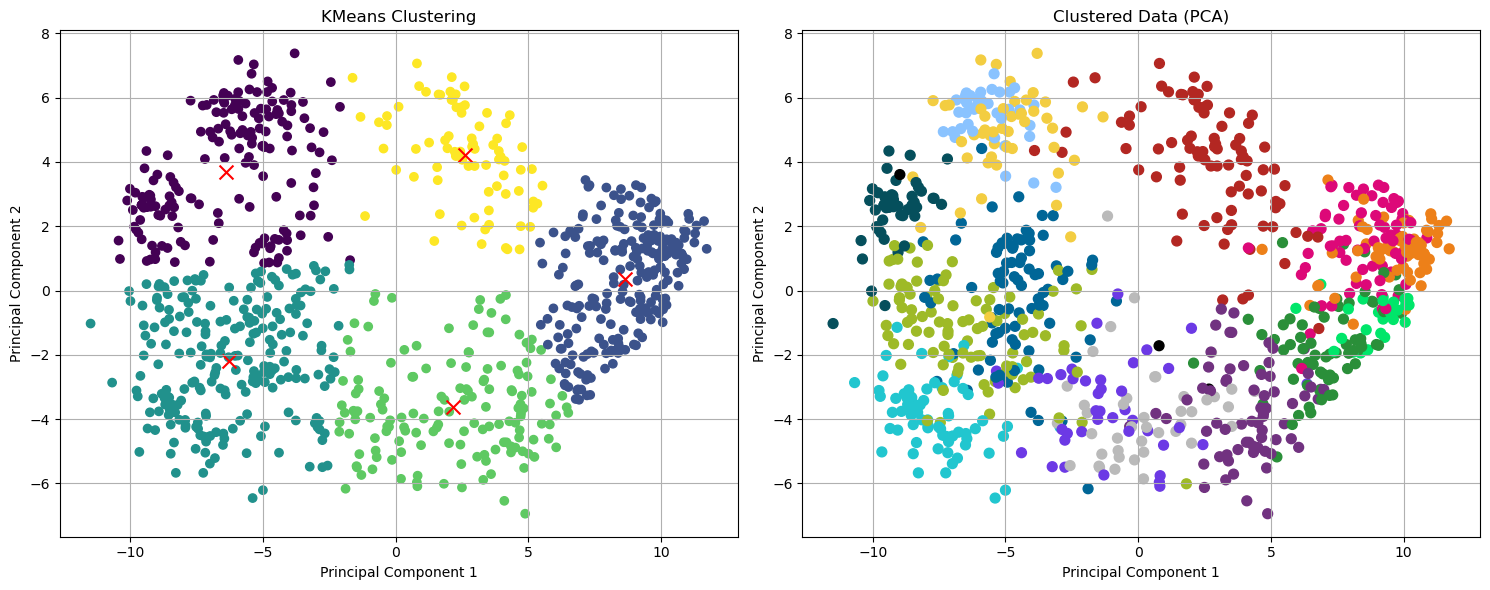

In [41]:
do_kmeans(5)

Agglomerative clustering

In [42]:
def plot_dendrogram(method):
    fig, ax = plt.subplots(figsize=(20, 5))
    
    linkage_array = linkage(X_pca, method=method)
    dendrogram(linkage_array, ax=ax)
    ax.set_ylabel('Distance')

    plt.show()

def plot_agg_clustering(k, method):
    fig, ax = plt.subplots(figsize=(20, 5))
    agg = AgglomerativeClustering(n_clusters=k, linkage=method)
    labels = agg.fit_predict(X_pca)
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50, alpha=0.5)
    
    plt.show()

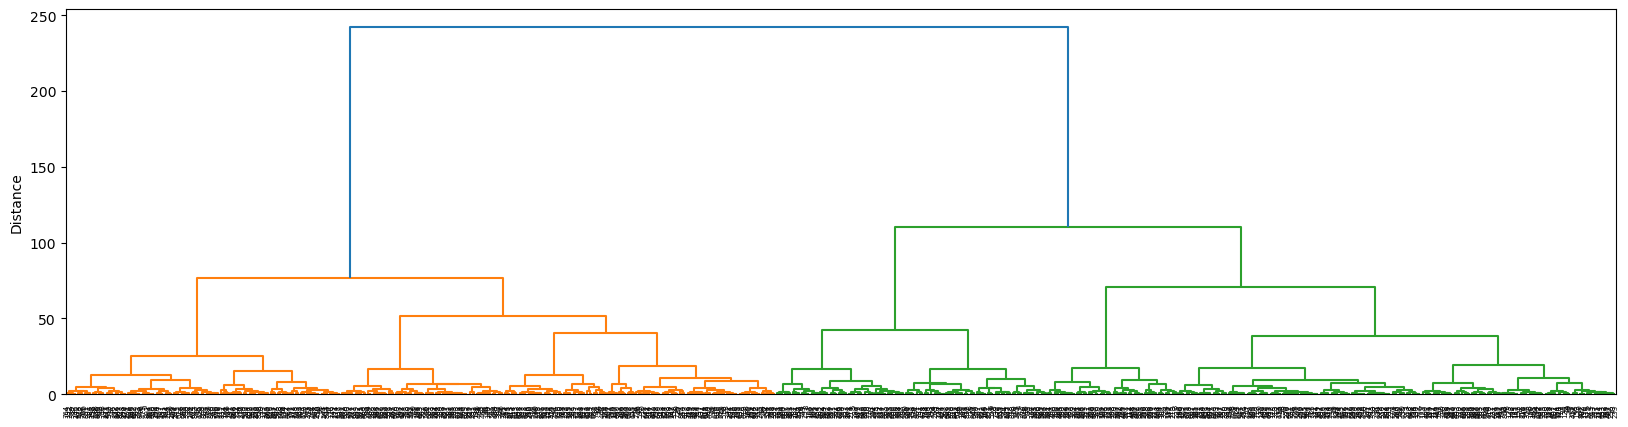

In [43]:
plot_dendrogram('ward')

We identify by looking at the plot that k=3.

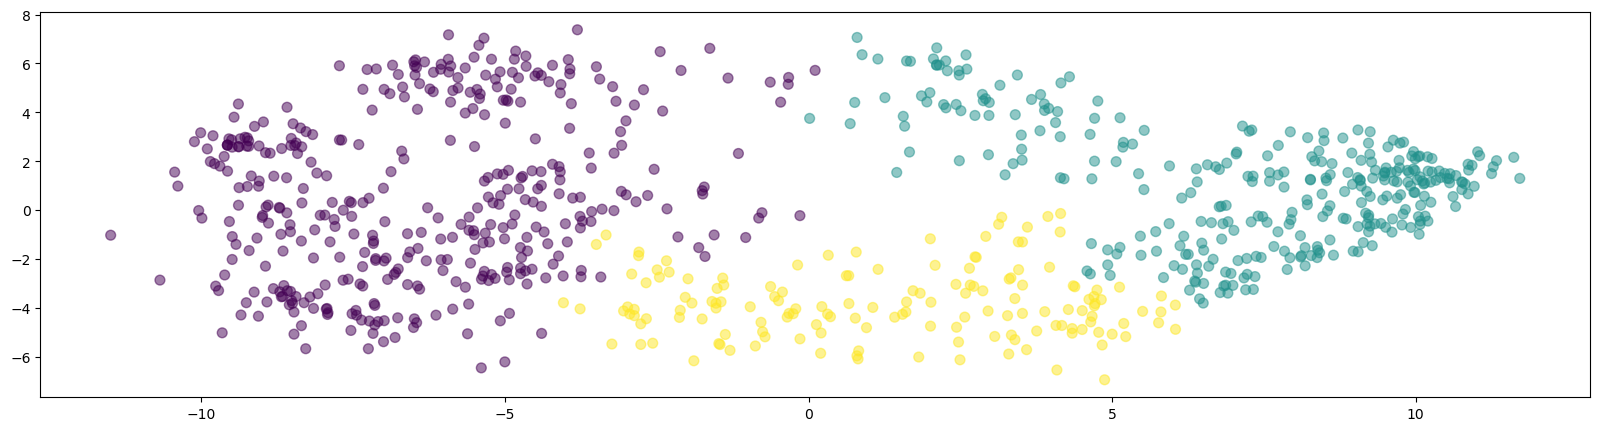

In [44]:
plot_agg_clustering(3, 'ward')

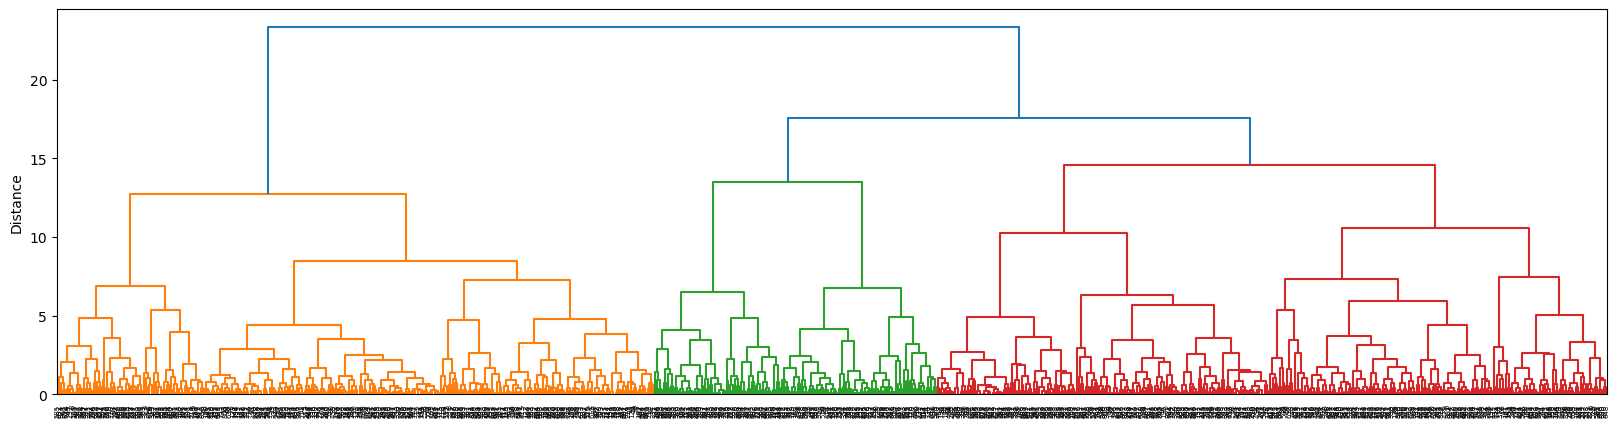

In [45]:
plot_dendrogram('complete')

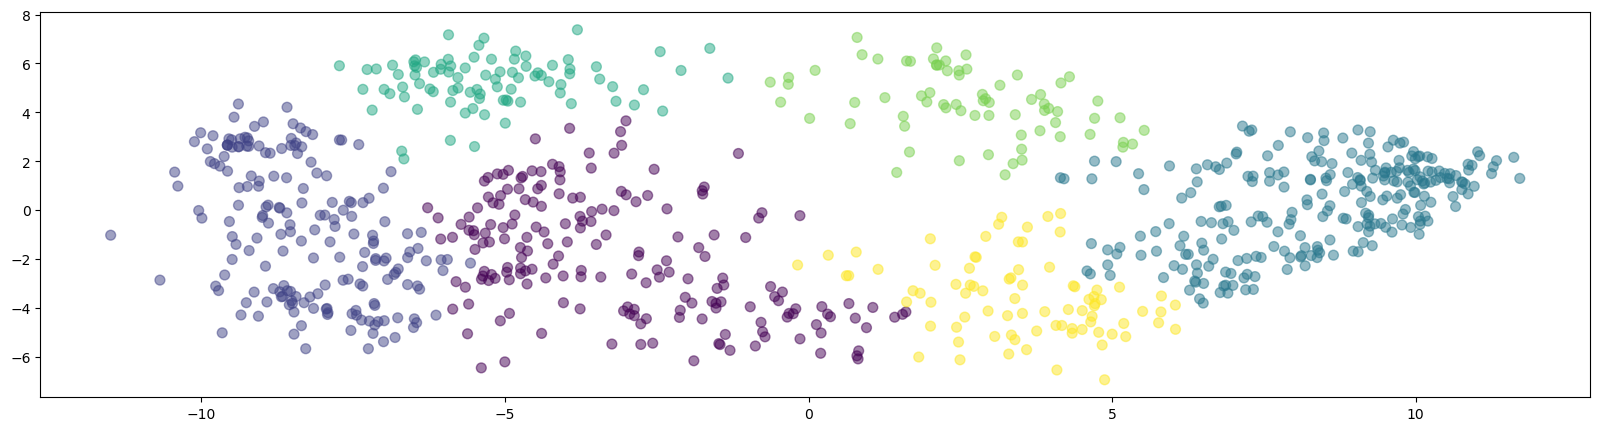

In [49]:
plot_agg_clustering(6, 'complete')

DBSCAN

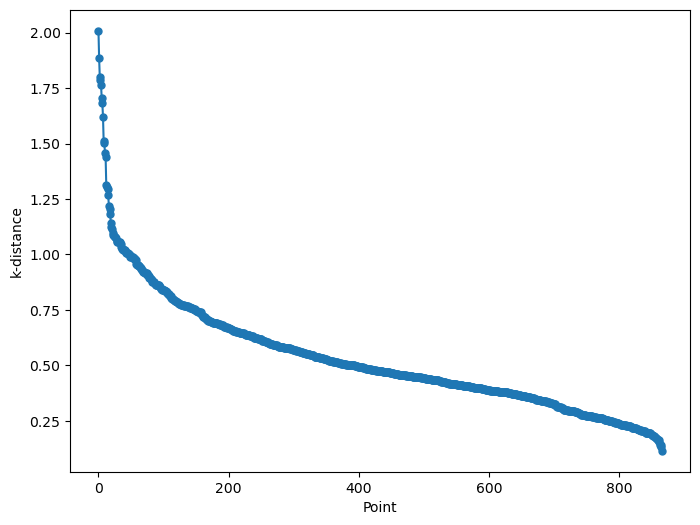

In [47]:
def calculate_k_distance(X, k):
    k_distance = []
    for i in range(len(X)):
        dist = []
        for j in range(len(X)):
            dist.append(np.linalg.norm(X[i, :] - X[j, :]))
        dist.sort()
        k_distance.append(dist[k])
    k_distance.sort(reverse=True)
    return k_distance

k = 4
k_distances = calculate_k_distance(X_pca, k)

plt.figure(figsize=(8, 6))
plt.plot(range(len(X_pca)), k_distances, '.-', markersize=10)
plt.xlabel('Point')
plt.ylabel('k-distance')
plt.show()

Epsilon around 1.30

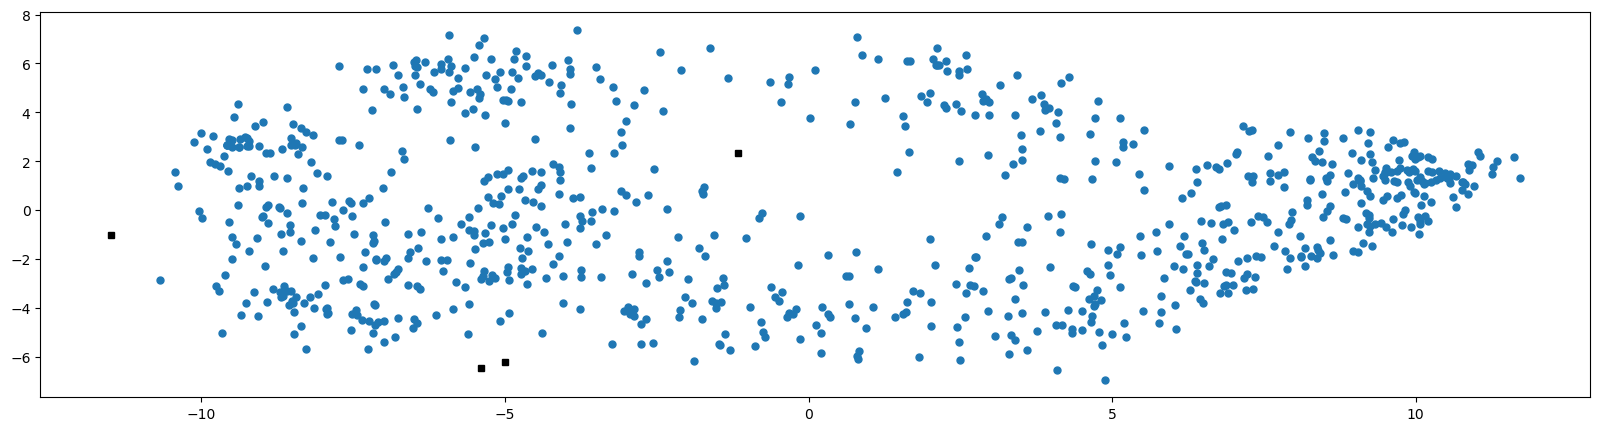

In [48]:
def plot_dbscan(eps):
    fig, ax = plt.subplots(figsize=(20, 5))
    X = X_pca
    dbscan = DBSCAN(eps=eps, min_samples=4)
    label = dbscan.fit_predict(X)
    for j in range(k):
        ax.plot(X[label == j, 0], X[label == j, 1], '.', markersize=10, label=j)
    ax.plot(X[label == -1, 0], X[label == -1, 1], 'sk', markersize=4, label=-1)
    plt.show()

plot_dbscan(1.30)  

In our dataset the density varies a lot, which explains why the DBSCAN did not perform well - it assumes that the clusters have approximately uniform density.